<h1>QUALITY OF LIVING CITY RANKING ANALYSIS</h1>
<h2>Applied Data Science Capstone Project</h2>

In [1]:
# Import libraries
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import requests as request
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import types
from botocore.client import Config
import ibm_boto3
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [427]:
#Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
# Define Foursquare Version and Credentials 
VERSION = '20180605' # Foursquare API version
LIMIT=50
CLIENT_ID = 'EDTFWJEZYDXJ4URCIECIVXYDYCJEEXIGTAZJPG0QMWX223HA' # my Foursquare ID
CLIENT_SECRET = 'CQH2L1KWZV13PCE2FAY5XWIWQAZKMZUW1YERFG5HUYYDX4OU' # my Foursquare Secret 
print ('Foursquare credentials defined')

Foursquare credentials defined


In [428]:
# Get data with cities coordinates from World Cities Database  https://simplemaps.com/data/world-cities which is loaded as csv file onto local computer

def __iter__(self): return 0

#@hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_524537aaa1094703be3ca0986ace8489 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Wpvs2ch3rQjwOgPmcEDlzFksaVxc8Nl6udtBahwN3uJz',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_524537aaa1094703be3ca0986ace8489.get_object(Bucket='qualityoflivingcityrankinganalysi-donotdelete-pr-za0htycctxxdaw',Key='worldcities_upd_pop.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

cities_coordinates = pd.read_csv(body)
print('Dataframe with City geographical coordinates and other data. Dataframe shape:', cities_coordinates.shape)
cities_coordinates.head()

Dataframe with City geographical coordinates and other data. Dataframe shape: (12946, 11)


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1.901597e+09
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1.901360e+09
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1.901609e+09
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1.901852e+09
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1.901329e+09


In [429]:
# Let's drop unuseful columns
cities_coordinates.drop(['city_ascii','iso2','iso3','admin_name','capital','id'], axis=1,inplace=True)
cities_coordinates.head()

,city,lat,lng,country,population
0,Malishevë,42.4822,20.7458,Kosovo,NaN
1,Prizren,42.2139,20.7397,Kosovo,NaN
2,Zubin Potok,42.9144,20.6897,Kosovo,NaN
3,Kamenicë,42.5781,21.5803,Kosovo,NaN
4,Viti,42.3214,21.3583,Kosovo,NaN


In [430]:
# Form dataframe with venue types and categorits from Foursquare venue categories hierarchy as published on https://developer.foursquare.com/docs/resources/categories

body = client_524537aaa1094703be3ca0986ace8489.get_object(Bucket='qualityoflivingcityrankinganalysi-donotdelete-pr-za0htycctxxdaw',Key='Venue types.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

venueTypeDF = pd.read_csv(body,sep=';')
venueTypeDF.columns = ['Venue Type','Venue Category']
print('Venue Types and categories data. Dataframe shape:',venueTypeDF.shape)
#print(venueTypeDF.head(10))
print('Venue categories grouped by Venue type')
venueTypeDF.groupby('Venue Type').count()

Venue Types and categories data. Dataframe shape: (927, 2)
Venue categories grouped by Venue type


,Venue Category
Venue Type,
Arts & Entertainment,64
College & University,38
Event,12
Food,347
Nightlife Spot,24
Outdoors & Recreation,107
Professional & Other Places,105
Residence,5
Shop & Service,172


In [431]:
# Get data about QUALITY OF LIVING CITY RANKING from Mercer's research https://mobilityexchange.mercer.com/Insights/quality-of-living-rankings

# Make a beatiful soup (scraping) of Mercer's site page using the BeautifulSoup package
city_ranking_soup = BeautifulSoup(request.get("https://mobilityexchange.mercer.com/Insights/quality-of-living-rankings").text,'html.parser')

# Find 2 tables with ranking of cities in HTML soup it after inspection of the page
city_ranking_tables = city_ranking_soup.findAll('table', class_='table table-striped')

# Transform HTML with table into dataframe containing city ranking data CRdf
CRdf = pd.read_html(str(city_ranking_tables))[0]
CRdf=CRdf.append(pd.read_html(str(city_ranking_tables))[1],ignore_index=False)

# Let's check what we have got
print('Dataframe with QUALITY OF LIVING CITY RANKING. Dataframe shape:', CRdf.shape)
CRdf.head()

Dataframe with QUALITY OF LIVING CITY RANKING. Dataframe shape: (231, 3)


,Rank,City,Country/Region
0,1,Vienna,Austria
1,2,Zürich,Switzerland
2,3,Vancouver,Canada
3,3,Munich,Germany
4,3,Auckland,New Zealand


In [432]:
# We need a table with City ranks, coordinates and population let's merge two dataframe

CRCdf = CRdf.join(cities_coordinates.set_index('city'), on='City')
print(CRCdf.shape)
CRCdf.head()

(318, 7)


,Rank,City,Country/Region,lat,lng,country,population
0,1,Vienna,Austria,48.2000,16.3666,Austria,2400000.0
0,1,Vienna,Austria,38.8996,-77.2597,United States,16544.0
0,1,Vienna,Austria,39.3238,-81.5383,United States,10370.0
1,2,Zürich,Switzerland,47.3800,8.5500,Switzerland,1108000.0
2,3,Vancouver,Canada,49.2734,-123.1216,Canada,2313328.0


In [433]:
# Let's check cities without coordinates
len(CRCdf[CRCdf['lat'].isna()])

0

In [434]:
# As we can see in the resulting table we have duplicated cities as we have a lot of cities with identical name around the world
# Let's select only cities with a same country
CRCDdf = CRCdf[CRCdf['Country/Region'] == CRCdf['country']]
CRCDdf.reset_index(inplace=True)
print(CRCDdf.shape)
CRCDdf.head()

(231, 8)


,index,Rank,City,Country/Region,lat,lng,country,population
0,0,1,Vienna,Austria,48.2000,16.3666,Austria,2400000.0
1,1,2,Zürich,Switzerland,47.3800,8.5500,Switzerland,1108000.0
2,2,3,Vancouver,Canada,49.2734,-123.1216,Canada,2313328.0
3,3,3,Munich,Germany,48.1299,11.5750,Germany,1275000.0
4,4,3,Auckland,New Zealand,-36.8481,174.7630,New Zealand,1377200.0


In [ ]:
# drop columns index and country
CRCDdf.drop(['index','country'], axis=1,inplace=True)
CRCDdf.head()

In [437]:
# Let's check cities without population
len(CRCDdf[CRCDdf['population'].isna()])

0

In [438]:
CRCDdf.shape

(231, 6)

In [439]:
# create map of World  using world's coordinates
WorldLocation = [0.0, 0.0]
map_World = folium.Map(WorldLocation, zoom_start=3)
map_World

In [440]:
# add markers of cities to map
for lat, lng, city, country, rank in zip(CRCDdf['lat'], CRCDdf['lng'], CRCDdf['City'], CRCDdf['Country/Region'],CRCDdf['Rank']):
    label = 'City: {}, Country: {}, Rank: {}'.format(city, country, rank)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_World)  
map_World

In [442]:
# Create a function for all venues exploring or searching aroud defined location
# We can use 2 methods 1) EXPLORE or 2) SEARCH depending on analysis results
# 1) EXPLORE METHOD
def ExploreNearbyVenues(names, latitudes, longitudes, radius=100, LIMIT=10):
    
    venues_list=[]
    print('Cities venues EXPLORATION with radius=',radius,'LIMIT=',LIMIT)
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = request.get(url).json()["response"]['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
                print('NoGroupERROR')
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
   
      
    return(nearby_venues)


In [448]:
# 2) SEARCH METHOD

def SearchNearbyVenues(names, latitudes, longitudes, radius=100, LIMIT=10):
    
    venues_list=[]
    print('Cities venues SEARCHING with radius=',radius,'LIMIT=',LIMIT)
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent=browse'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = request.get(url).json()["response"]["venues"] 
        
        # return only relevant information for each nearby venue
        
        for v in results:
            if len(v['categories']) != 0: #select only venue with categories
                venues_list.append([(
                       name, 
                       lat, 
                       lng, 
                       v['name'], 
                       v['location']['lat'], 
                       v['location']['lng'],  
                       v['categories'][0]['name'])])
               
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [445]:
# Here we can select group of city for analysis CAdf. For example, top 5 cities with the highest rank or the lowest rank. Or we can get all the cities for analysis.
#CAdf = CRCdf.head(5) # for example top 5 cities
#CAdf = CRCdf.tail(5) # for examplr 5 cities with the lowest rank
CAdf=CRCDdf # we will examine all 231 cities
print(CAdf.shape)
CAdf.head()

(231, 6)


,Rank,City,Country/Region,lat,lng,population
0,1,Vienna,Austria,48.2000,16.3666,2400000.0
1,2,Zürich,Switzerland,47.3800,8.5500,1108000.0
2,3,Vancouver,Canada,49.2734,-123.1216,2313328.0
3,3,Munich,Germany,48.1299,11.5750,1275000.0
4,3,Auckland,New Zealand,-36.8481,174.7630,1377200.0


In [449]:
# Now run the above function on city venues and create a new dataframe called City_venues by Search method.

City_venues = SearchNearbyVenues(names= CAdf['City'], latitudes=CAdf['lat'], longitudes=CAdf['lng'],radius=3000, LIMIT=500)
print(City_venues.shape)              
City_venues.head()

Cities venues SEARCHING with radius= 3000 LIMIT= 500
Vienna
Zürich
Vancouver
Munich
Auckland
Düsseldorf
Frankfurt
Copenhagen
Geneva
Basel
Sydney
Amsterdam
Berlin
Bern
Wellington
Toronto
Melbourne
Luxembourg
Ottawa
Hamburg
Perth
Montréal
Nuremburg
Stockholm
Oslo
Singapore
Stuttgart
Brussels
Adelaide
Canberra
Helsinki
Calgary
Dublin
San Francisco
Brisbane
Boston
Lisbon
Honolulu
Paris
Lyon
Milan
London
Barcelona
New York
Edinburgh
Madrid
Seattle
Glasgow
Kobe
Tokyo
Birmingham
Chicago
Washington
Philadelphia
Yokohama
Rome
Aberdeen
Osaka
Pittsburgh
Leipzig
Minneapolis
Nagoya
Dallas
Belfast
Atlanta
Houston
Los Angeles
Miami
Prague
St. Louis
Hong Kong
Pointe-à-Pitre
Detroit
Ljubljana
Dubai
Budapest
Seoul
Abu Dhabi
Montevideo
Bratislava
Vilnius
Warsaw
Port Louis
Taipei
Kuala Lumpur
Limassol
Tallinn
Durban
Athens
Riga
Buenos Aires
San Juan
Santiago
Busan
Cape Town
Johannesburg
Panama City
Zagreb
Victoria
Wroclaw
Johor Bahru
Taichung
Shanghai
Tel Aviv
Muscat
Bandar Seri Begawan
Brasilia
San José


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vienna,48.2,16.3666,Novomatic Forum,48.200035,16.366388,Diner
1,Vienna,48.2,16.3666,Opern-Wurst-Stadl,48.200029,16.366854,Hot Dog Joint
2,Vienna,48.2,16.3666,Novomatic Forum,48.200025,16.366360,Art Gallery
3,Vienna,48.2,16.3666,U Karlsplatz,48.200345,16.368817,Metro Station
4,Vienna,48.2,16.3666,Secession,48.200504,16.365767,Art Museum


In [450]:
# Let's try analyse venues by venue type (not by venue category)
# Merge resulting table with venue type and category data to add corresponding coulms

City_venues = pd.merge(City_venues,venueTypeDF, on=['Venue Category'])
print(City_venues.shape)
City_venues.head()



(30171, 8)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Type
0,Vienna,48.2000,16.3666,Novomatic Forum,48.200035,16.366388,Diner,Food
1,Auckland,-36.8481,174.7630,The Observatory,-36.848510,174.762315,Diner,Food
2,Amsterdam,52.3500,4.9166,Chef's Kantoortje,52.349805,4.918577,Diner,Food
3,Melbourne,-37.8200,144.9750,Mid Town Popup Diner,-37.817532,144.972930,Diner,Food
4,Ottawa,45.4167,-75.7000,Friendly Corner Deli,45.417622,-75.697946,Diner,Food


In [451]:
# We have more than 30 000 venues in our dataframe
# Let's check how many venues were returned for cities by venue type
City_venues.groupby('Venue Type')['Venue'].count().sort_values(ascending=False)


Venue Type
Professional & Other Places    7987
Shop & Service                 6637
Food                           5937
Travel & Transport             2619
Outdoors & Recreation          1720
Nightlife Spot                 1588
Arts & Entertainment           1510
College & University           1096
Residence                      1044
Event                            33
Name: Venue, dtype: int64

In [452]:
# It seems that Event type is not representative and shoud be dropped later
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(City_venues['Venue Type'].unique())))

There are 10 uniques categories.


In [456]:
# Let's check how many venues we have for each city
City_venues.groupby('City')['Venue'].count().sort_values(ascending=False)

City
Nassau          195
Abidjan         194
Istanbul        189
Nagoya          189
Hong Kong       188
Athens          188
Paris           188
Limassol        187
Port Louis      187
Asunción        186
Luxembourg      185
Ashgabat        184
Taipei          184
Rabat           184
San Juan        183
La Paz          183
Leipzig         182
Tegucigalpa     182
Taichung        182
Amman           181
Budapest        181
Tunis           180
Glasgow         180
Tashkent        180
Shenzhen        179
Ottawa          179
Bogotá          178
Chongqing       178
Barcelona       178
Gaborone        177
               ... 
New Delhi        89
Victoria         87
Buenos Aires     87
Tel Aviv         85
Muscat           84
Ouagadougou      83
Belfast          83
Pittsburgh       81
Havana           80
Vancouver        79
Bangui           77
Bangkok          77
Miami            77
Quito            76
Vientiane        74
Busan            72
Tripoli          64
Stockholm        62
Copenhagen     

In [457]:
# Analyze Each city
# one hot encoding
City_onehot = pd.get_dummies(City_venues[['Venue Type']], prefix="", prefix_sep="")

# add City columns back to dataframe
City_onehot['City'] = City_venues['City'] 

# move City columns to the first column
fixed_columns = [City_onehot.columns[-1]] + list(City_onehot.columns[:-1])
City_onehot = City_onehot[fixed_columns]
print(City_onehot.shape)
City_onehot.head()

(30171, 11)


,City,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Vienna,0,0,0,1,0,0,0,0,0,0
1,Auckland,0,0,0,1,0,0,0,0,0,0
2,Amsterdam,0,0,0,1,0,0,0,0,0,0
3,Melbourne,0,0,0,1,0,0,0,0,0,0
4,Ottawa,0,0,0,1,0,0,0,0,0,0


In [459]:
# Next, let's group rows by City and by taking the mean of the frequency of occurrence of each category
City_grouped = City_onehot.groupby('City').mean().reset_index()
print(City_grouped.shape)
City_grouped.head()

(231, 11)


,City,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Aberdeen,0.029586,0.248521,0.0,0.088757,0.053254,0.112426,0.130178,0.082840,0.159763,0.094675
1,Abidjan,0.051546,0.082474,0.0,0.077320,0.036082,0.020619,0.536082,0.030928,0.108247,0.056701
2,Abu Dhabi,0.026087,0.008696,0.0,0.147826,0.017391,0.060870,0.478261,0.026087,0.200000,0.034783
3,Abuja,0.026316,0.013158,0.0,0.131579,0.111842,0.078947,0.434211,0.039474,0.092105,0.072368
4,Accra,0.036810,0.036810,0.0,0.055215,0.055215,0.012270,0.411043,0.024540,0.331288,0.036810


In [460]:
# Let's drop venue with type Event as we mentionned before
CGdf=City_grouped
CGdf.drop(['Event'], axis=1,inplace=True)
print(CGdf.shape)
CGdf.head()

(231, 10)


,City,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Aberdeen,0.029586,0.248521,0.088757,0.053254,0.112426,0.130178,0.082840,0.159763,0.094675
1,Abidjan,0.051546,0.082474,0.077320,0.036082,0.020619,0.536082,0.030928,0.108247,0.056701
2,Abu Dhabi,0.026087,0.008696,0.147826,0.017391,0.060870,0.478261,0.026087,0.200000,0.034783
3,Abuja,0.026316,0.013158,0.131579,0.111842,0.078947,0.434211,0.039474,0.092105,0.072368
4,Accra,0.036810,0.036810,0.055215,0.055215,0.012270,0.411043,0.024540,0.331288,0.036810


In [461]:
# Let's put that into a pandas dataframe

# First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 9

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues

columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Cities_venues_sorted = pd.DataFrame(columns=columns)
Cities_venues_sorted['City'] = CGdf['City']

for ind in np.arange(CGdf.shape[0]):
    Cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CGdf.iloc[ind, :], num_top_venues)

print(Cities_venues_sorted.shape)
Cities_venues_sorted.head()

(231, 10)


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Aberdeen,College & University,Shop & Service,Professional & Other Places,Outdoors & Recreation,Travel & Transport,Food,Residence,Nightlife Spot,Arts & Entertainment
1,Abidjan,Professional & Other Places,Shop & Service,College & University,Food,Travel & Transport,Arts & Entertainment,Nightlife Spot,Residence,Outdoors & Recreation
2,Abu Dhabi,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,Nightlife Spot,College & University
3,Abuja,Professional & Other Places,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,College & University
4,Accra,Professional & Other Places,Shop & Service,Nightlife Spot,Food,Travel & Transport,College & University,Arts & Entertainment,Residence,Outdoors & Recreation


1 13.146774855073406
2 9.748569971538892
3 7.868317458512998
4 6.74803642307427
5 6.16537054343498
6 5.718363914847828
7 5.360710543911819
8 5.019420368409162
9 4.749007775037902
10 4.492000841354252
11 4.191154303152052
12 3.9745543795556317
13 3.7241918514980226
14 3.5333401419859216


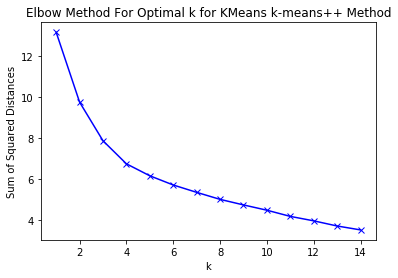

In [462]:
# Cluster Cities
# Run k-means to cluster the cities 

# find the best number of clusters first
City_grouped_clustering = CGdf.drop('City', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(City_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    print(k,km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k for KMeans k-means++ Method')
plt.show()

In [463]:
# We can suppose that elbow point is when k=4
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(City_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10]) 

[3 1 1 1 1 3 1 0 2 0]


In [464]:
print(City_grouped_clustering.shape)
City_grouped_clustering.head()

(231, 9)


,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.029586,0.248521,0.088757,0.053254,0.112426,0.130178,0.082840,0.159763,0.094675
1,0.051546,0.082474,0.077320,0.036082,0.020619,0.536082,0.030928,0.108247,0.056701
2,0.026087,0.008696,0.147826,0.017391,0.060870,0.478261,0.026087,0.200000,0.034783
3,0.026316,0.013158,0.131579,0.111842,0.078947,0.434211,0.039474,0.092105,0.072368
4,0.036810,0.036810,0.055215,0.055215,0.012270,0.411043,0.024540,0.331288,0.036810


In [465]:
#Let's create a new dataframe that includes the cluster as well as the top 9 venues categories for each city.
# add clustering labels
Cities_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
print(Cities_venues_sorted.shape)
Cities_venues_sorted.head()

(231, 11)


,Cluster,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,3,Aberdeen,College & University,Shop & Service,Professional & Other Places,Outdoors & Recreation,Travel & Transport,Food,Residence,Nightlife Spot,Arts & Entertainment
1,1,Abidjan,Professional & Other Places,Shop & Service,College & University,Food,Travel & Transport,Arts & Entertainment,Nightlife Spot,Residence,Outdoors & Recreation
2,1,Abu Dhabi,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,Nightlife Spot,College & University
3,1,Abuja,Professional & Other Places,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,College & University
4,1,Accra,Professional & Other Places,Shop & Service,Nightlife Spot,Food,Travel & Transport,College & University,Arts & Entertainment,Residence,Outdoors & Recreation


In [466]:
# Insert clusters to dataframe
City_grouped_clustering.insert(0, 'Cluster', kmeans.labels_)
print(City_grouped_clustering.shape)
City_grouped_clustering.head()

(231, 10)


,Cluster,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,3,0.029586,0.248521,0.088757,0.053254,0.112426,0.130178,0.082840,0.159763,0.094675
1,1,0.051546,0.082474,0.077320,0.036082,0.020619,0.536082,0.030928,0.108247,0.056701
2,1,0.026087,0.008696,0.147826,0.017391,0.060870,0.478261,0.026087,0.200000,0.034783
3,1,0.026316,0.013158,0.131579,0.111842,0.078947,0.434211,0.039474,0.092105,0.072368
4,1,0.036810,0.036810,0.055215,0.055215,0.012270,0.411043,0.024540,0.331288,0.036810


In [467]:
# merge City_merged with CAdf data to add latitude/longitude and Rank for each city 

City_merged = pd.merge(Cities_venues_sorted,CAdf, on=['City'])
print(City_merged.shape)
City_merged.head()

(231, 16)


,Cluster,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,Rank,Country/Region,lat,lng,population
0,3,Aberdeen,College & University,Shop & Service,Professional & Other Places,Outdoors & Recreation,Travel & Transport,Food,Residence,Nightlife Spot,Arts & Entertainment,57,United Kingdom,57.1704,-2.0800,189364.0
1,1,Abidjan,Professional & Other Places,Shop & Service,College & University,Food,Travel & Transport,Arts & Entertainment,Nightlife Spot,Residence,Outdoors & Recreation,208,Cote d'Ivoire,5.3200,-4.0400,3802000.0
2,1,Abu Dhabi,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,Nightlife Spot,College & University,78,United Arab Emirates,24.4667,54.3666,603492.0
3,1,Abuja,Professional & Other Places,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,College & University,213,Nigeria,9.0833,7.5333,1576000.0
4,1,Accra,Professional & Other Places,Shop & Service,Nightlife Spot,Food,Travel & Transport,College & University,Arts & Entertainment,Residence,Outdoors & Recreation,165,Ghana,5.5500,-0.2167,2121000.0


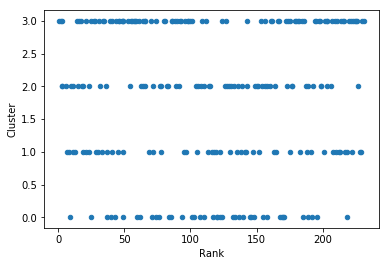

In [468]:
# Let's check possible correlation between Cluster and Rank of city
City_merged.plot(kind='scatter',x='Rank',y='Cluster')
plt.show()

In [469]:
# Finally, let's visualize the resulting clusters

# create map
map_clusters = folium.Map(WorldLocation, zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rank in zip(City_merged['lat'], City_merged['lng'], City_merged['City'], City_merged['Cluster'],City_merged['Rank']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Rank '+ str(rank), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [471]:
# Let's examine Clusters
# Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 
# Based on the defining categories, we can then assign a name to each cluster.

#Cluster 0 is FOR FOOD&SHOPPING
City_merged.loc[City_merged['Cluster'] == 0, City_merged.columns[[0] + list(range(0, City_merged.shape[1]))]]

,Cluster,Cluster,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,Rank,Country/Region,lat,lng,population
7,0,0,Algiers,Food,Professional & Other Places,Shop & Service,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Residence,College & University,Arts & Entertainment,185,Algeria,36.7631,3.0506,3354000.0
9,0,0,Amman,Food,Shop & Service,Travel & Transport,Professional & Other Places,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,Residence,College & University,120,Jordan,31.9500,35.9333,1060000.0
24,0,0,Barcelona,Food,Shop & Service,Travel & Transport,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Residence,Arts & Entertainment,College & University,43,Spain,41.3833,2.1834,4920000.0
26,0,0,Beijing,Food,Shop & Service,Professional & Other Places,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Residence,College & University,120,China,39.9289,116.3883,11106000.0
38,0,0,Brasilia,Food,Shop & Service,Professional & Other Places,Arts & Entertainment,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Residence,College & University,107,Brazil,-15.7833,-47.9161,3716996.0
44,0,0,Budapest,Travel & Transport,Shop & Service,Food,Professional & Other Places,Nightlife Spot,Residence,College & University,Outdoors & Recreation,Arts & Entertainment,76,Hungary,47.5000,19.0833,1679000.0
46,0,0,Busan,Food,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Professional & Other Places,Travel & Transport,Residence,Nightlife Spot,College & University,94,South Korea,35.0951,129.0100,3480000.0
52,0,0,Casablanca,Food,Professional & Other Places,Travel & Transport,Arts & Entertainment,Outdoors & Recreation,Shop & Service,Nightlife Spot,College & University,Residence,124,Morocco,33.6000,-7.6164,3181000.0
53,0,0,Chengdu,Food,Travel & Transport,Shop & Service,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Residence,College & University,134,China,30.6700,104.0700,4123000.0
56,0,0,Chongqing,Food,Travel & Transport,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Professional & Other Places,Nightlife Spot,Residence,College & University,148,China,29.5650,106.5950,6461000.0


In [472]:
#Cluster 1 ONLY FOR WORKING but you can eat here and make some sopping
City_merged.loc[City_merged['Cluster'] == 1, City_merged.columns[[0] + list(range(0, City_merged.shape[1]))]]

,Cluster,Cluster,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,Rank,Country/Region,lat,lng,population
1,1,1,Abidjan,Professional & Other Places,Shop & Service,College & University,Food,Travel & Transport,Arts & Entertainment,Nightlife Spot,Residence,Outdoors & Recreation,208,Cote d'Ivoire,5.3200,-4.0400,3802000.0
2,1,1,Abu Dhabi,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,Nightlife Spot,College & University,78,United Arab Emirates,24.4667,54.3666,603492.0
3,1,1,Abuja,Professional & Other Places,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Arts & Entertainment,College & University,213,Nigeria,9.0833,7.5333,1576000.0
4,1,1,Accra,Professional & Other Places,Shop & Service,Nightlife Spot,Food,Travel & Transport,College & University,Arts & Entertainment,Residence,Outdoors & Recreation,165,Ghana,5.5500,-0.2167,2121000.0
6,1,1,Adelaide,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation,Travel & Transport,Nightlife Spot,College & University,Arts & Entertainment,Residence,29,Australia,-34.9350,138.6000,1145000.0
10,1,1,Amsterdam,Professional & Other Places,Food,Travel & Transport,Shop & Service,Residence,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment,11,Netherlands,52.3500,4.9166,1031000.0
31,1,1,Berlin,Professional & Other Places,Shop & Service,Food,Travel & Transport,Outdoors & Recreation,College & University,Arts & Entertainment,Nightlife Spot,Residence,13,Germany,52.5218,13.4015,3406000.0
49,1,1,Canberra,Professional & Other Places,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Shop & Service,Nightlife Spot,Food,Residence,College & University,30,Australia,-35.2830,149.1290,327700.0
50,1,1,Cape Town,Professional & Other Places,Shop & Service,Arts & Entertainment,Travel & Transport,Food,Outdoors & Recreation,Nightlife Spot,College & University,Residence,95,South Africa,-33.9200,18.4350,3215000.0
55,1,1,Chicago,Professional & Other Places,Shop & Service,Travel & Transport,Food,College & University,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Residence,49,United States,41.8373,-87.6861,8675982.0


In [473]:
#Cluster 2 FIRST SOPPING than working
City_merged.loc[City_merged['Cluster'] == 2, City_merged.columns[[0] + list(range(0, City_merged.shape[1]))]]

,Cluster,Cluster,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,Rank,Country/Region,lat,lng,population
8,2,2,Almaty,Shop & Service,Professional & Other Places,Food,Outdoors & Recreation,Travel & Transport,Residence,College & University,Arts & Entertainment,Nightlife Spot,177,Kazakhstan,43.3250,76.9150,1209000.0
13,2,2,Asunción,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation,Arts & Entertainment,Residence,Nightlife Spot,College & University,Travel & Transport,115,Paraguay,-25.2964,-57.6415,1870000.0
14,2,2,Athens,Shop & Service,Professional & Other Places,Food,College & University,Nightlife Spot,Travel & Transport,Arts & Entertainment,Outdoors & Recreation,Residence,89,Greece,37.9833,23.7333,3242000.0
15,2,2,Atlanta,Shop & Service,Professional & Other Places,Food,Outdoors & Recreation,Travel & Transport,Residence,Nightlife Spot,Arts & Entertainment,College & University,64,United States,33.7626,-84.4228,5228750.0
20,2,2,Bandar Seri Begawan,Food,Shop & Service,Professional & Other Places,Outdoors & Recreation,College & University,Travel & Transport,Residence,Arts & Entertainment,Nightlife Spot,106,Brunei,4.8833,114.9333,296500.0
21,2,2,Bangkok,Shop & Service,Professional & Other Places,Food,Outdoors & Recreation,Travel & Transport,College & University,Nightlife Spot,Residence,Arts & Entertainment,133,Thailand,13.7500,100.5166,6704000.0
25,2,2,Basel,Shop & Service,Food,Professional & Other Places,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Residence,College & University,10,Switzerland,47.5804,7.5900,830000.0
29,2,2,Belgrade,Shop & Service,Food,Professional & Other Places,Nightlife Spot,Residence,Travel & Transport,Arts & Entertainment,Outdoors & Recreation,College & University,139,Serbia,44.8186,20.4680,1099000.0
30,2,2,Bengaluru,Shop & Service,Professional & Other Places,Food,Travel & Transport,Residence,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,College & University,149,India,12.9700,77.5600,6787000.0
34,2,2,Bishkek,Shop & Service,Professional & Other Places,Residence,Food,Travel & Transport,Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,College & University,206,Kyrgyzstan,42.8731,74.5852,837000.0


In [474]:
#Cluster 3 MIXED you can do here what you want
City_merged.loc[City_merged['Cluster'] == 3, City_merged.columns[[0] + list(range(0, City_merged.shape[1]))]]

,Cluster,Cluster,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,Rank,Country/Region,lat,lng,population
0,3,3,Aberdeen,College & University,Shop & Service,Professional & Other Places,Outdoors & Recreation,Travel & Transport,Food,Residence,Nightlife Spot,Arts & Entertainment,57,United Kingdom,57.170400,-2.080000,189364.0
5,3,3,Addis Ababa,Professional & Other Places,Food,Shop & Service,Travel & Transport,College & University,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Residence,209,Ethiopia,9.033300,38.700000,3100000.0
11,3,3,Antananarivo,Food,Professional & Other Places,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,College & University,Travel & Transport,Residence,214,Madagascar,-18.916600,47.516600,1697000.0
12,3,3,Ashgabat,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation,Nightlife Spot,Residence,Arts & Entertainment,Travel & Transport,College & University,211,Turkmenistan,37.950000,58.383300,727700.0
16,3,3,Auckland,Food,Professional & Other Places,Shop & Service,Travel & Transport,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,College & University,Residence,3,New Zealand,-36.848100,174.763000,1377200.0
17,3,3,Baghdad,Professional & Other Places,Shop & Service,Food,Travel & Transport,College & University,Outdoors & Recreation,Arts & Entertainment,Residence,Nightlife Spot,231,Iraq,33.338600,44.393900,5054000.0
18,3,3,Baku,Professional & Other Places,Shop & Service,Food,College & University,Residence,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,195,Azerbaijan,40.395300,49.862200,2122300.0
19,3,3,Bamako,Food,Professional & Other Places,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,College & University,Residence,220,Mali,12.650000,-8.000000,1494000.0
22,3,3,Bangui,Professional & Other Places,Food,Travel & Transport,Outdoors & Recreation,Arts & Entertainment,Shop & Service,Residence,Nightlife Spot,College & University,230,Central African Republic,4.366600,18.558300,831925.0
23,3,3,Banjul,Professional & Other Places,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Residence,College & University,Arts & Entertainment,179,Gambia,13.453900,-16.591700,43094.0


In [475]:
# Let's form our final dataframes

CityDF=City_merged.sort_values(by=['Rank'])

print(CityDF.shape)
CityDF.head()

(231, 16)


,Cluster,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,Rank,Country/Region,lat,lng,population
216,3,Vienna,College & University,Food,Professional & Other Places,Shop & Service,Arts & Entertainment,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Residence,1,Austria,48.2000,16.3666,2400000.0
230,3,Zürich,Food,Professional & Other Places,College & University,Shop & Service,Nightlife Spot,Travel & Transport,Outdoors & Recreation,Arts & Entertainment,Residence,2,Switzerland,47.3800,8.5500,1108000.0
16,3,Auckland,Food,Professional & Other Places,Shop & Service,Travel & Transport,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,College & University,Residence,3,New Zealand,-36.8481,174.7630,1377200.0
214,2,Vancouver,Shop & Service,Professional & Other Places,Food,Arts & Entertainment,Residence,Travel & Transport,Outdoors & Recreation,Nightlife Spot,College & University,3,Canada,49.2734,-123.1216,2313328.0
143,2,Munich,Shop & Service,Nightlife Spot,Food,Professional & Other Places,Travel & Transport,Arts & Entertainment,Residence,Outdoors & Recreation,College & University,3,Germany,48.1299,11.5750,1275000.0


In [476]:
# Lets create new dataframe for city analysis with venue frequency and city rank
City_Venue_RankDF = pd.merge(City_grouped,CAdf, on=['City'])
City_Venue_RankDF.insert(0, 'Cluster', kmeans.labels_)
print(City_Venue_RankDF.shape)
City_Venue_RankDF.head()

(231, 16)


,Cluster,City,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Rank,Country/Region,lat,lng,population
0,3,Aberdeen,0.029586,0.248521,0.088757,0.053254,0.112426,0.130178,0.082840,0.159763,0.094675,57,United Kingdom,57.1704,-2.0800,189364.0
1,1,Abidjan,0.051546,0.082474,0.077320,0.036082,0.020619,0.536082,0.030928,0.108247,0.056701,208,Cote d'Ivoire,5.3200,-4.0400,3802000.0
2,1,Abu Dhabi,0.026087,0.008696,0.147826,0.017391,0.060870,0.478261,0.026087,0.200000,0.034783,78,United Arab Emirates,24.4667,54.3666,603492.0
3,1,Abuja,0.026316,0.013158,0.131579,0.111842,0.078947,0.434211,0.039474,0.092105,0.072368,213,Nigeria,9.0833,7.5333,1576000.0
4,1,Accra,0.036810,0.036810,0.055215,0.055215,0.012270,0.411043,0.024540,0.331288,0.036810,165,Ghana,5.5500,-0.2167,2121000.0


In [477]:
City_Venue_RankDF.sort_values(by=['Rank'],inplace=True)
print(City_Venue_RankDF.shape)
City_Venue_RankDF.head()

(231, 16)


,Cluster,City,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Rank,Country/Region,lat,lng,population
216,3,Vienna,0.086331,0.273381,0.215827,0.021583,0.043165,0.165468,0.000000,0.129496,0.064748,1,Austria,48.2000,16.3666,2400000.0
230,3,Zürich,0.021277,0.191489,0.276596,0.063830,0.042553,0.212766,0.000000,0.148936,0.042553,2,Switzerland,47.3800,8.5500,1108000.0
16,3,Auckland,0.070588,0.041176,0.247059,0.076471,0.041176,0.229412,0.023529,0.170588,0.100000,3,New Zealand,-36.8481,174.7630,1377200.0
214,2,Vancouver,0.088608,0.000000,0.164557,0.000000,0.012658,0.291139,0.037975,0.379747,0.025316,3,Canada,49.2734,-123.1216,2313328.0
143,2,Munich,0.041322,0.000000,0.115702,0.140496,0.016529,0.107438,0.016529,0.495868,0.066116,3,Germany,48.1299,11.5750,1275000.0
